In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('../data/train.csv')
data=pd.get_dummies(data,columns=["Sex","Pclass"],dtype=int)
data['Age'] = data['Age'].fillna(value = data['Age'].median())
data.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
count,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,310.500000,0.393548,29.404839,0.538710,0.382258,31.746982,0.372581,0.627419,0.240323,0.209677,0.550000
std,179.122863,0.488931,12.810898,1.086018,0.792131,45.907139,0.483882,0.483882,0.427624,0.407407,0.497895
min,1.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,155.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,310.500000,0.000000,28.000000,0.000000,0.000000,14.750000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,465.250000,1.000000,35.000000,1.000000,0.000000,30.548950,1.000000,1.000000,0.000000,0.000000,1.000000
max,620.000000,1.000000,71.000000,8.000000,5.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

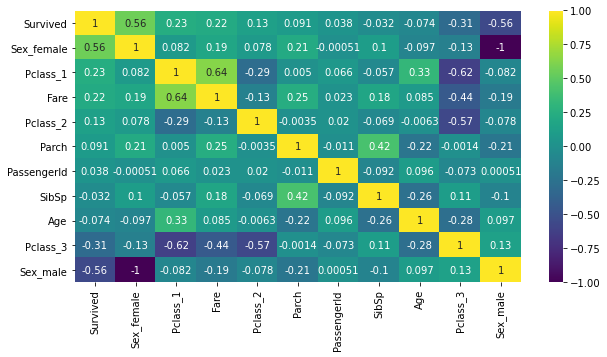

In [3]:
cols=data.corr().nlargest(len(data),'Survived')['Survived'].index
cm=data[cols].corr()
plt.figure(figsize=(10,5))
sns.heatmap(cm,annot=True,cmap='viridis')

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>],
       [<AxesSubplot:title={'center':'Sex_female'}>,
        <AxesSubplot:title={'center':'Sex_male'}>,
        <AxesSubplot:title={'center':'Pclass_1'}>],
       [<AxesSubplot:title={'center':'Pclass_2'}>,
        <AxesSubplot:title={'center':'Pclass_3'}>, <AxesSubplot:>]],
      dtype=object)

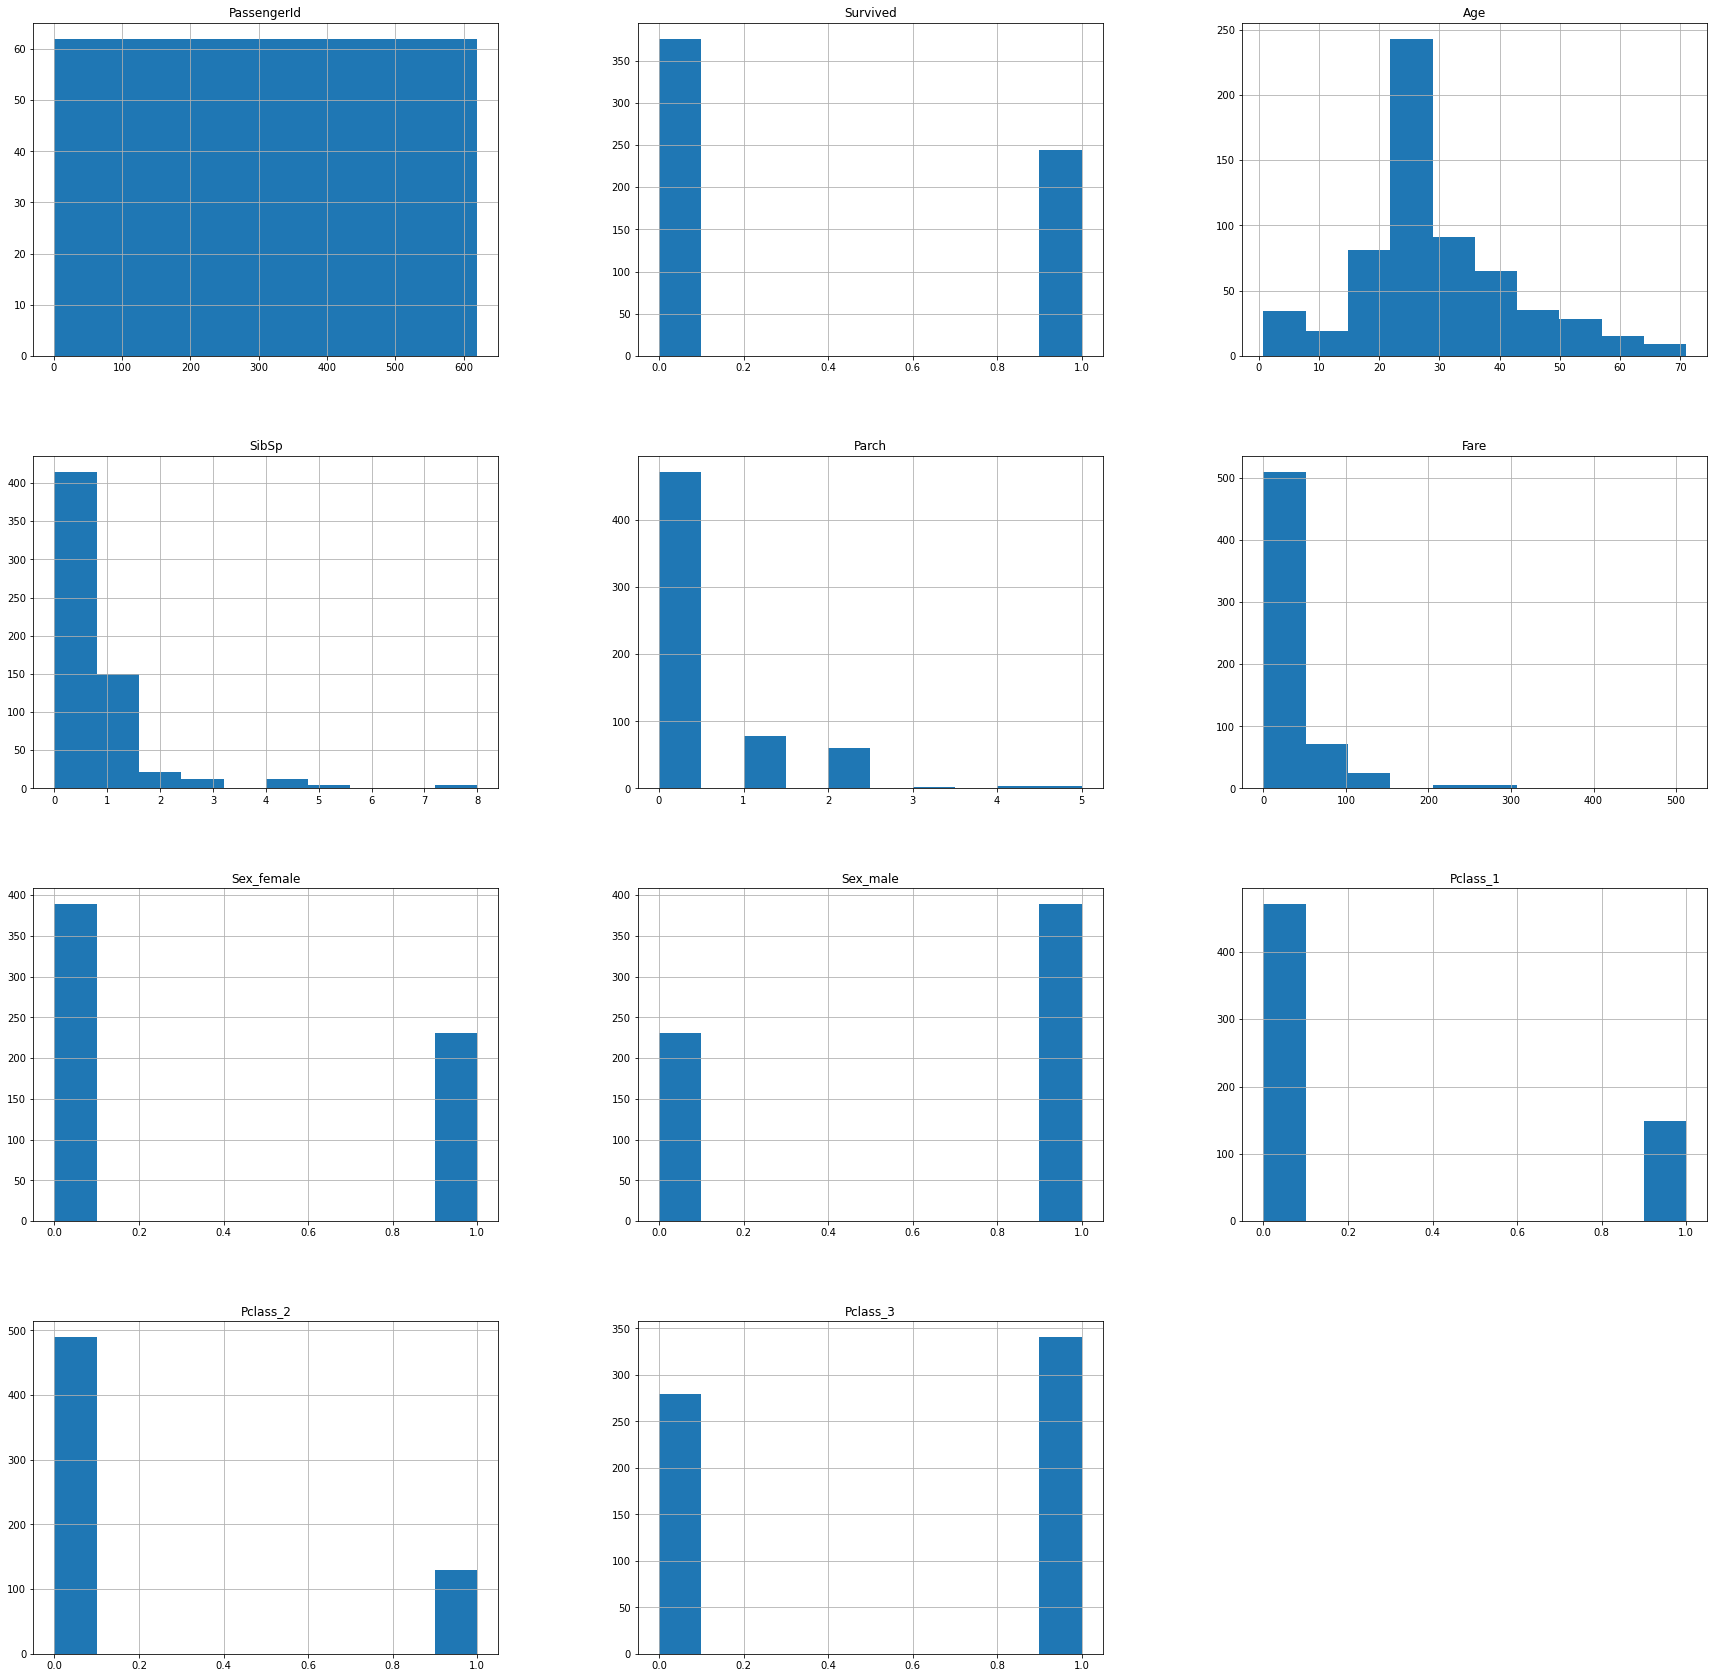

In [4]:
data.hist(figsize = (30,30))

# Without regularisation

In [5]:
Y=np.array(data["Survived"])
data.drop(["Survived","PassengerId"],axis=1,inplace=True)
minx=data.min()
maxx=data.max()
df=(data-minx)/(maxx-minx)
df.insert(0,'X_0',np.ones((len(df),1)))
X=np.array(df)
w=np.ones(X.shape[1])

In [6]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [7]:
def optimize(w,X,Y):
    m=X.shape[0]
    z=np.dot(X,w)
    a=sigmoid(z)
    cost=(-1/m)*(np.dot(Y.T,np.log(a)+np.dot(1-Y.T,np.log(1-a))))
    dw=(1/m)*np.dot(X.T,a-Y)
    return dw,cost

In [8]:
def train(w,X,Y,alpha,no_iter):
    costs=[]
    for i in range(no_iter):
        dw,cost=optimize(w,X,Y)
        w=w-alpha*dw
        if(i%100==0):
            costs.append(cost)
    return w,costs

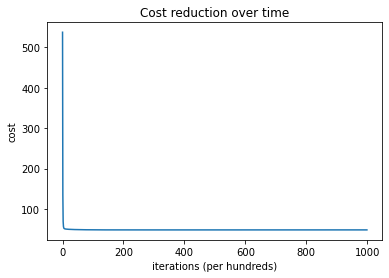

In [9]:
final_w,costs=train(w,X,Y,0.03,100000)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.show()

In [10]:
test_data=pd.read_csv('../data/test.csv')
test_data=pd.get_dummies(test_data,columns=["Sex","Pclass"],dtype=int)
test_Y=np.array(test_data["Survived"])
test_data['Age'] = test_data['Age'].fillna(value = test_data['Age'].median())
test_data.drop(["Survived","PassengerId"],axis=1,inplace=True)
test_df=(test_data-minx)/(maxx-minx)
test_df.insert(0,'X_0',np.ones((len(test_df),1)))
test_X=np.array(test_df)

In [11]:
def predict(final_w,X):
    y_predict=np.zeros((X.shape[0],1))
    m=X.shape[0]
    z=np.dot(X,final_w)
    a=np.reshape(sigmoid(z),(z.shape[0],1))
    y_predict=a>0.5
    return y_predict,a

In [12]:
def accuracy(y_predict,true_y):
    return np.sum(y_predict==true_y)*100/y_predict.shape[0]

In [13]:
y_test_predict,test_a=predict(final_w,test_X)
y_train_predict,train_a=predict(final_w,X)

In [14]:
def f1_score(y_predict,true_y):
    tp=np.sum(y_predict&true_y)
    precision=tp/np.sum(y_predict)
    recall=tp/np.sum(true_y)
    f1=2*tp/(np.sum(true_y)+np.sum(y_predict))
    print(f"Precision= {precision:.2f}")
    print(f"Recall= {recall:.2f}")
    print(f"F1 Score= {f1:.2f}")

In [15]:
print("TRAIN SET")
print(f"Accuracy = {accuracy(y_train_predict,Y.reshape(Y.shape[0],1)):0.2f}%")
f1_score(y_train_predict,Y.reshape(Y.shape[0],1))
print(f"Loss={(-1/Y.shape[0])*(np.dot(Y.T,np.log(train_a)+np.dot(1-Y.T,np.log(1-train_a))))[0]:0.2f}")
print("TEST SET")
print(f"Test Accuracy = {accuracy(y_test_predict,np.reshape(test_Y,(test_Y.shape[0],1))):.2f}%")
f1_score(y_test_predict,test_Y.reshape(test_Y.shape[0],1))
print(f"Loss={(-1/test_Y.shape[0])*(np.dot(test_Y.T,np.log(test_a)+np.dot(1-test_Y.T,np.log(1-test_a))))[0]:.2f}")

TRAIN SET
Accuracy = 80.65%
Precision= 0.78
Recall= 0.71
F1 Score= 0.74
Loss=48.68
TEST SET
Test Accuracy = 80.44%
Precision= 0.78
Recall= 0.63
F1 Score= 0.70
Loss=18.10


# Regularisation

In [16]:
df2=pd.concat([data,np.square(data)],axis=1)
minx2=df2.min()
maxx2=df2.max()
df2=(df2-minx2)/(maxx2-minx2)
df2.insert(0,'X_0',np.ones((len(df2),1)))
X2=np.array(df2)
test_df2=pd.concat([test_data,np.square(test_data)],axis=1)
test_df2=(test_df2-minx2)/(maxx2-minx2)
test_df2.insert(0,'X_0',np.ones((len(test_df2),1)))
test_X2=np.array(test_df2)
w2=np.ones(X2.shape[1])

In [17]:
def optimize2(w2,x,y,lmbd):
    m=x.shape[0]
    z=np.dot(x,w2)
    a=sigmoid(z)
    w2[0]=0
    cost2=(-1/m)*(np.dot(y.T,np.log(a)+np.dot(1-y.T,np.log(1-a))))+(lmbd/(2*m))*np.dot(w2.T,w2)
    dw2=(1/m)*np.dot(x.T,a-y)+(lmbd/m)*w2
    return dw2,cost2

In [18]:
def train2(w2,x,y,alpha,lmbd,no_iter):
    costs2=[]
    for i in range(no_iter):
        dw2,cost2=optimize2(w2,x,y,lmbd)
        w2=w2-alpha*dw2
        if(i%100==0):
            costs2.append(cost2)
    return w2,costs2

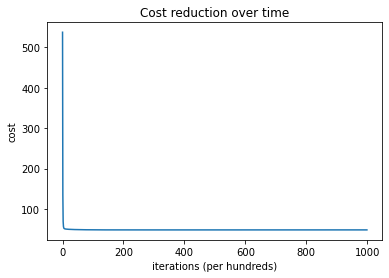

In [19]:
final_w2,costs2=train2(w2,X2,Y,0.03,1,100000)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.show()

In [20]:
y_test_predict2,test_a2=predict(final_w2,test_X2)
y_train_predict2,train_a2=predict(final_w2,X2)

In [21]:
print("TRAIN SET")
print(f"Accuracy = {accuracy(y_train_predict2,Y.reshape(Y.shape[0],1)):0.2f}%")
f1_score(y_train_predict2,Y.reshape(Y.shape[0],1))
print(f"Loss={(-1/Y.shape[0])*(np.dot(Y.T,np.log(train_a2)+np.dot(1-Y.T,np.log(1-train_a2))))[0]:0.2f}")
print("TEST SET")
print(f"Test Accuracy = {accuracy(y_test_predict2,np.reshape(test_Y,(test_Y.shape[0],1))):.2f}%")
f1_score(y_test_predict2,test_Y.reshape(test_Y.shape[0],1))
print(f"Loss={(-1/test_Y.shape[0])*(np.dot(test_Y.T,np.log(test_a2)+np.dot(1-test_Y.T,np.log(1-test_a2))))[0]:.2f}")

TRAIN SET
Accuracy = 79.84%
Precision= 0.76
Recall= 0.70
F1 Score= 0.73
Loss=48.62
TEST SET
Test Accuracy = 79.70%
Precision= 0.78
Recall= 0.61
F1 Score= 0.69
Loss=18.01
